In [ ]:
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# Step 2: Download dataset from Kaggle
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'imdb-dataset-of-50k-movie-reviews' dataset.
Path to dataset files: /kaggle/input/imdb-dataset-of-50k-movie-reviews


In [ ]:
# Step 3: Load data
df = pd.read_csv(path + "/IMDB Dataset.csv")
print(df.head())

texts = df['review'].values
labels = (df['sentiment'] == "positive").astype(int).values

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [ ]:
# Step 4: Preprocess
vocab_size = 10000
max_len = 200

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded = pad_sequences(sequences, maxlen=max_len, truncating="post")

X_train, X_test, y_train, y_test = train_test_split(padded, labels, test_size=0.2, random_state=42)

In [ ]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [ ]:
# Step 5: Create Dataset & DataLoader
class IMDBDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = IMDBDataset(X_train, y_train)
test_dataset = IMDBDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
# Step 6: Build RNN Model
class SimpleRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(SimpleRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded)
        out = self.fc(hidden[-1])  # last hidden state
        return self.sigmoid(out)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleRNN(vocab_size, embed_dim=64, hidden_dim=64, output_dim=1).to(device)
print(model)

SimpleRNN(
  (embedding): Embedding(10000, 64)
  (rnn): RNN(64, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
# Step 7: Loss & Optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Step 8: Train
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(20):
    model.train()
    epoch_loss, correct, total = 0, 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        predicted = (outputs >= 0.5).float()
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

    train_loss = epoch_loss / len(train_loader)
    train_acc = correct / total

    # Validation
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            predicted = (outputs >= 0.5).float()
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

    val_loss /= len(test_loader)
    val_acc = correct / total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
          f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")


Epoch 1: Train Loss=0.3256, Train Acc=0.8641, Val Loss=0.7856, Val Acc=0.6801
Epoch 2: Train Loss=0.3210, Train Acc=0.8688, Val Loss=0.7983, Val Acc=0.6749
Epoch 3: Train Loss=0.3050, Train Acc=0.8760, Val Loss=0.7216, Val Acc=0.7135
Epoch 4: Train Loss=0.2701, Train Acc=0.8941, Val Loss=0.7445, Val Acc=0.7027
Epoch 5: Train Loss=0.2730, Train Acc=0.8937, Val Loss=0.7598, Val Acc=0.7119
Epoch 6: Train Loss=0.2948, Train Acc=0.8832, Val Loss=0.7781, Val Acc=0.6876
Epoch 7: Train Loss=0.3100, Train Acc=0.8716, Val Loss=0.7568, Val Acc=0.6956
Epoch 8: Train Loss=0.3122, Train Acc=0.8725, Val Loss=0.7807, Val Acc=0.6946
Epoch 9: Train Loss=0.3023, Train Acc=0.8770, Val Loss=0.7500, Val Acc=0.7046
Epoch 10: Train Loss=0.3038, Train Acc=0.8758, Val Loss=0.7628, Val Acc=0.7017
Epoch 11: Train Loss=0.2903, Train Acc=0.8826, Val Loss=0.8051, Val Acc=0.6982
Epoch 12: Train Loss=0.2761, Train Acc=0.8902, Val Loss=0.7696, Val Acc=0.7118
Epoch 13: Train Loss=0.2631, Train Acc=0.8966, Val Loss=0.820

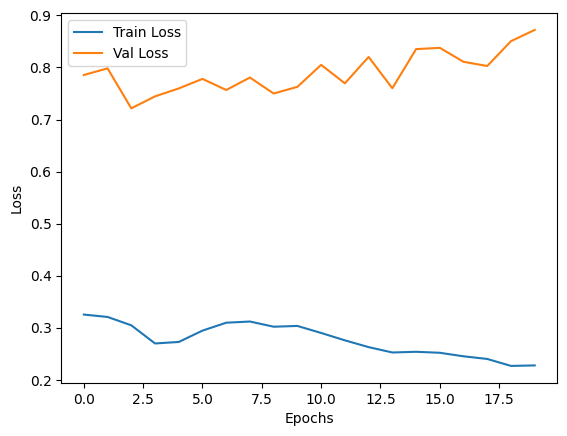

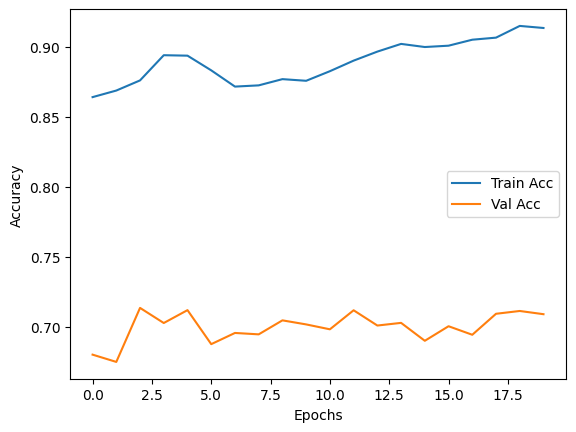

In [ ]:
# Step 9: Plot results
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch).squeeze()
        predicted = (outputs >= 0.5).float()
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(y_batch.cpu().numpy())

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.71      0.70      0.70      4961
         1.0       0.71      0.72      0.71      5039

    accuracy                           0.71     10000
   macro avg       0.71      0.71      0.71     10000
weighted avg       0.71      0.71      0.71     10000

